In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import streamlit as st
# ✅ 가장 먼저 페이지 설정
st.set_page_config(page_title="CPI 예측 대시보드", layout="wide")
import seaborn as sns
from streamlit_pandas_profiling import st_profile_report
from ydata_profiling import ProfileReport

2025-03-25 17:15:33.860 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
c:\test\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'




# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False




# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format


In [6]:
# 1. 파일 경로 및 데이터 불러오기
file_cpi = "dataset/cpi.csv" # 소비자 물가지수
file_rate = "dataset/interest_rate.csv" # 기준금리
file_ex = "dataset/exchange_rate.csv" # 환율
# encoding="CP949": 한글이 포함된 파일일 경우 CP949 인코딩
# skiprows=2    파일 상단의 설명이나 불필요한 행(예: 출처, 단위 등) 2줄을 건너뜁니다.
cpi_raw = pd.read_csv(file_cpi, encoding="CP949", skiprows=2)
rate_raw = pd.read_csv(file_rate, encoding="CP949", skiprows=2)
ex_raw = pd.read_csv(file_ex, encoding="CP949", skiprows=2)

In [7]:
# 2. CPI 데이터 전처리
# 원본 데이터를 변경하지 않고 안전하게 작업
cpi_data = cpi_raw.copy()
cpi_data.rename(columns={"Unnamed: 0": "날짜"}, inplace=True)
# 첫 번째 행(인덱스 0)에 컬럼 이름이 한 번 더 들어가 있는 경우
# .reset_index(drop=True) : 줄 번호를 처음부터 다시 정리
# drop=True: 원래 번호(3번, 4번, 5번)를 기억 안 해도 돼요
# 만약 drop=False로 하면 이렇게 옛날 번호도 같이 보여줘요
cpi_data = cpi_data[1:].reset_index(drop=True)
# 날짜라는 열에서 "월"이라는 글자를 없애는 코드
# .astype(str) :  날짜가 숫자로 되어 있으면, **글자(문자)**로 바꿔주는 거예요.
#  .str.replace("월", "", regex=False): "월"이라는 글자를 빈칸("")으로 바꾸는 거예요.
# regex=False는 “정규표현식”이라는 복잡한 걸 안 쓰고 그대로 문자만 찾겠다는 뜻이에요.
cpi_data["날짜"] = cpi_data["날짜"].astype(str).str.replace("월", "", regex=False)
# "날짜"라는 열에 다른 내용도 있음
# 숫자 6자리만 남기고 싶음
# ^ 문자열의 시작/\d  숫자 1개/{6}   숫자가 6개 연속/$ 문자열의 끝
#  즉, "처음부터 끝까지 숫자 6개만 있어야 한다!" 는 뜻
cpi_data = cpi_data[cpi_data["날짜"].str.match(r"^\d{6}$")]
# "200001" 같은 숫자 문자열을, 진짜 날짜로 바꾸는 것!
# "200001"을 → 2000년 1월 1일이라는 **진짜 날짜(datetime)**로 바꾸고 싶은 거예요
# pd.to_datetime()  → 글자처럼 생긴 날짜를 진짜 날짜로 바꿔줘요
# format="%Y%m" → 이 글자가 "연도+월" 형식이라는 걸 알려줘요
cpi_data["날짜"] = pd.to_datetime(cpi_data["날짜"], format="%Y%m")
# 날짜를 **"월(月) 단위 시계열"**로 정리
# 2000-01-15    2000-01 (월 단위)/“이 날짜는 2000년 1월에 속한다”라는 뜻
# .dt.to_timestamp() : 다시 날짜 형식으로 바꾸되, 그 달의 **첫째 날(1일)**로 바꿔줘요!
cpi_data["날짜"] = cpi_data["날짜"].dt.to_period("M").dt.to_timestamp()
cpi_data.rename(columns={"물가상승률": "CPI"}, inplace=True)
cpi_data = cpi_data[["날짜", "CPI"]]
# 비어 있는 칸(NaN)을 가진 행(row)을 없애는 것!
cpi_data.dropna(inplace=True)


In [8]:
# 3. 금리 데이터 전처리
# -------------------------------
rate_data = rate_raw.copy()
rate_data.rename(columns={"Unnamed: 0": "날짜"}, inplace=True)
rate_data = rate_data[1:].reset_index(drop=True)
rate_data["날짜"] = rate_data["날짜"].astype(str).str.replace("월", "", regex=False)
rate_data = rate_data[rate_data["날짜"].str.match(r"^\d{6}$")]
rate_data["날짜"] = pd.to_datetime(rate_data["날짜"], format="%Y%m")
rate_data["날짜"] = rate_data["날짜"].dt.to_period("M").dt.to_timestamp()
rate_data = rate_data[["날짜", "금리"]]
rate_data.dropna(inplace=True)


In [9]:
# 4. 환율 데이터 전처리
# -------------------------------
ex_data = ex_raw.copy()
ex_data.rename(columns={"Unnamed: 0": "날짜"}, inplace=True)
ex_data = ex_data[1:].reset_index(drop=True)
ex_data["날짜"] = ex_data["날짜"].astype(str).str.replace("월", "", regex=False)
ex_data = ex_data[ex_data["날짜"].str.match(r"^\d{6}$")]
ex_data["날짜"] = pd.to_datetime(ex_data["날짜"], format="%Y%m")
ex_data["날짜"] = ex_data["날짜"].dt.to_period("M").dt.to_timestamp()
ex_data = ex_data[["날짜", "환율"]]
ex_data.dropna(inplace=True)


In [10]:
# 5. 병합: 날짜 기준 inner join
# (날짜가 같은 행끼리만 합쳐요)
# how="inner": inner join은 세 표에 모두 있는 날짜만 남겨요!
# 데이터가 빠짐없이 존재하는 날짜만 사용해서 모델이 안정적으로 학습할 수 있게 합니다.
# on="날짜": **어떤 기준(열)**으로 합칠지 정해주는 옵션
merged_df = pd.merge(cpi_data, rate_data, on="날짜", how="inner")
merged_df = pd.merge(merged_df, ex_data, on="날짜", how="inner")


In [11]:
# 6. 결과 확인
# -------------------------------
print("\n✅ 병합된 데이터:")
print(merged_df.head())
print(merged_df.info())
print(merged_df.isnull().sum())
# 👉 CSV 파일로 저장
merged_df.to_csv("merged_cpi_dataset.csv", index=False, encoding="utf-8-sig")
print("✅ 병합된 데이터를 'merged_cpi_dataset.csv'로 저장 완료!")



✅ 병합된 데이터:
          날짜  CPI    금리       환율
0 2000-01-01  1.9  9.28  1,123.2
1 2000-02-01  1.8  8.99  1,131.0
2 2000-03-01  2.1  9.06  1,106.0
3 2000-04-01  1.4  8.95  1,109.1
4 2000-05-01  1.1  8.96  1,129.4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      301 non-null    datetime64[ns]
 1   CPI     301 non-null    object        
 2   금리      301 non-null    object        
 3   환율      301 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 9.5+ KB
None
날짜     0
CPI    0
금리     0
환율     0
dtype: int64
✅ 병합된 데이터를 'merged_cpi_dataset.csv'로 저장 완료!


In [12]:
# 쉼표 제거 + 숫자형 변환
# 환율에는 **쉼표(,)**가 있어서 Pandas가 이걸 숫자로 인식하지 못하고 **문자(str)**로 인식해버려요.
# .astype(str): 혹시 숫자나 다른 형식이 섞여 있어도 일단 문자열로 변환
# .str.replace(",", ""):쉼표 제거!
# pd.to_numeric(..., errors="coerce"):**문자열을 숫자(float)**로 변환/만약 숫자로 못 바꾸면(NaN 처리)
for col in ["CPI", "금리", "환율"]:
    merged_df[col] = merged_df[col].astype(str).str.replace(",", "")
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
merged_df.dropna(inplace=True) # 위에서 숫자로 못 바꾼 값이 있으면 NaN이 생깁니다.



In [13]:
# 숫자들을 0과 1 사이 값으로 압축해서 정규화(normalization)
# 데이터의 크기 차이 때문에 생기는 영향이 줄어들고,
# 머신러닝 모델이 훨씬 더 안정적으로 학습할 수 있어요!
scaler = MinMaxScaler()
# 데이터프레임에서 필요한 열만 선택
data_values = merged_df[["CPI", "금리", "환율"]].values
# 정규화 (0~1)
scaled = scaler.fit_transform(data_values)

In [14]:
# LSTM 모델에 넣기 위한 시계열 데이터셋을 만드는 핵심 함수
# look_back=12:과거 **12개월(12행)**의 데이터를 보고 그 다음 달의 CPI 값을 예측
# 입력 (X): 과거 CPI, 환율, 금리 (예: 지난 12개월)
# 출력 (y): 그 다음 달의 CPI
#
def create_lstm_dataset(data, look_back=12):
    """
    과거 CPI, 환율, 금리를 입력으로 사용하고,
    다음 달 CPI를 예측하는 LSTM 학습용 데이터 생성 함수


    Parameters:
        data (np.ndarray): 정규화된 데이터, shape = (총 기간, 3)
                           열 순서: [CPI, 금리, 환율]
        look_back (int): 사용할 과거 시점 수 (기본: 12개월)


    Returns:
        X (np.ndarray): LSTM 입력 시퀀스, shape = (샘플 수, look_back, 3)
        y (np.ndarray): 예측할 다음 달 CPI 값, shape = (샘플 수,)
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X_seq = data[i:i+look_back, :]       # 12개월치 CPI+금리+환율
        y_target = data[i + look_back, 0]    # 다음 달의 CPI (0번 열)
        X.append(X_seq)
        y.append(y_target)
   
    return np.array(X), np.array(y)


look_back = 12  # 과거 12개월 사용
X, y = create_lstm_dataset(scaled, look_back)
print("X shape:", X.shape)  # 예: (289, 12, 3)
print("y shape:", y.shape)  # 예: (289,)
# X.shape = (샘플 수, 시계열 길이, 변수 수)
# # 12개월, 3개 변수 (CPI, 금리, 환율)
# 출력 y: 일반적으로 1차원 또는 2차원
#1차원: (289,):각 샘플에 대해 예측할 값이 1개일 때 쓰는 가장 일반적인 형태예요/model.add(Dense(1))  # 결과가 1개니까 Dense(1)
# 2차원: (289, 1):이건 모양만 다르고 의미는 동일





X shape: (289, 12, 3)
y shape: (289,)


In [15]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])


c:\test\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# 모델 구조 확인
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
# mean_squared_error: 모델이 예측한 값과 실제 정답 사이의 차이(오차)를 얼마나 크게 틀렸는지 계산하는 기준

In [18]:
# train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]






In [19]:
# 조기 종료 설정
#모델이 더 이상 좋아지지 않으면,
#기다리지 않고 학습을 일찍 멈추는 기능이에요!
#그리고 가장 좋았던 상태의 모델 가중치로 되돌립니다.
#monitor='val_loss':무엇을 기준으로 멈출지를 설정합니다
#여기서는 val_loss → **검증 손실(Validation Loss)**이 줄어드는 걸 감시합니다
#patience=10:10번 연속으로 성능이 좋아지지 않으면 멈춰라!
#restore_best_weights=True:모델이 가장 잘 나왔던 시점의 가중치로 되돌립니다.
#즉, 학습을 계속해서 성능이 나빠졌더라도, 👉 가장 좋았던 상태로 저장해줍니다
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0952 - val_loss: 0.0199
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0205 - val_loss: 0.0167
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0163 - val_loss: 0.0086
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0163 - val_loss: 0.0078
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0113 - val_loss: 0.0079
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0130 - val_loss: 0.0075
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120 - val_loss: 0.0078
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0131 - val_loss: 0.0077
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0109 - val_loss: 0.0084
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


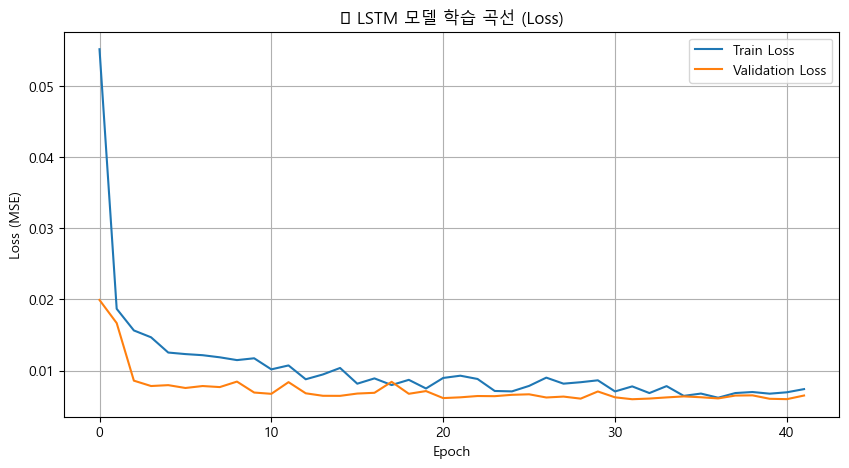

In [21]:
# 학슴 과정 (Loss) 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('🔧 LSTM 모델 학습 곡선 (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(history.history['loss'])
print(f"학습이 {actual_epochs}번째 에폭에서 완료되었습니다.")

학습이 42번째 에폭에서 완료되었습니다.


In [23]:
# 모델 저장
joblib.dump(model, 'cpi_model.pkl')

['cpi_model.pkl']

In [24]:
y_pred = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


In [25]:
# CPI 위치는 0번째 열
#예측 결과를 정규화된 값에서 원래 값으로 되돌리는 (역정규화)
#전처리된 값을 원래 실제값으로
#MinMaxScaler.inverse_transform()은 **입력 데이터 전체 (3개 변수)**가 있어야 동작
#1열짜리(CPI만) 데이터를 그냥 넣으면 오류가 나거나 이상한 결과가 나와요.
#해결 방법: CPI + 0으로 채운 금리/환율 → 3열 구성 후 역정규화
# Step 1: np.zeros((len(y_pred), 2))
#zeros()는 "0으로 가득 채워줘!" 라는 함수예요
#np.zeros((289, 2))의 의미:289행 2열짜리 배열을 만들고,모든 값을 0.0으로 채운 것!
# Step 2: np.concatenate([...], axis=1):CPI + [금리=0, 환율=0]을 붙여서 3열짜리로 만듭니다
#Step 3: scaler.inverse_transform(...):정규화된 값을 → 원래 값으로 되돌려줍니다
'''[[정규화된_CPI1, 정규화된_금리1, 정규화된_환율1],
 [정규화된_CPI2, 정규화된_금리2, 정규화된_환율2],
 ... ]
 
 '''
y_pred_inv = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), 2))], axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 2))], axis=1))[:, 0]


In [26]:


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f},R²: {r2:.4f}")


MAE: 0.8835, RMSE: 1.1036,R²: 0.5419


c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


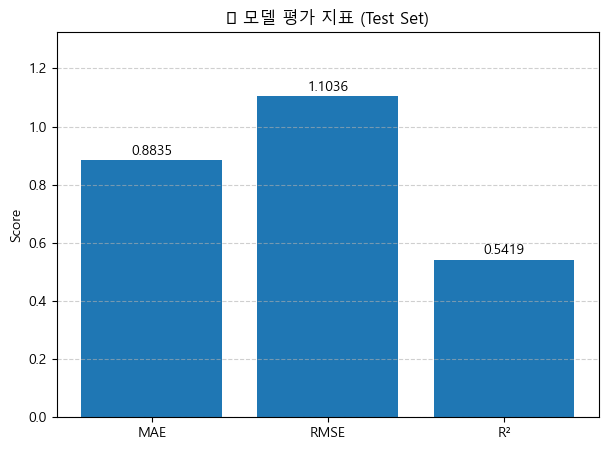

In [27]:
# 평가 지표 값 정리
metrics = ['MAE', 'RMSE', 'R²']
values = [mae, rmse, r2]

# 시각화
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics, values)
plt.title('📊 모델 평가 지표 (Test Set)')
plt.ylabel('Score')
plt.ylim(0, max(values)*1.2)  # 여유 공간 확보

# 바 위에 수치 표기
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

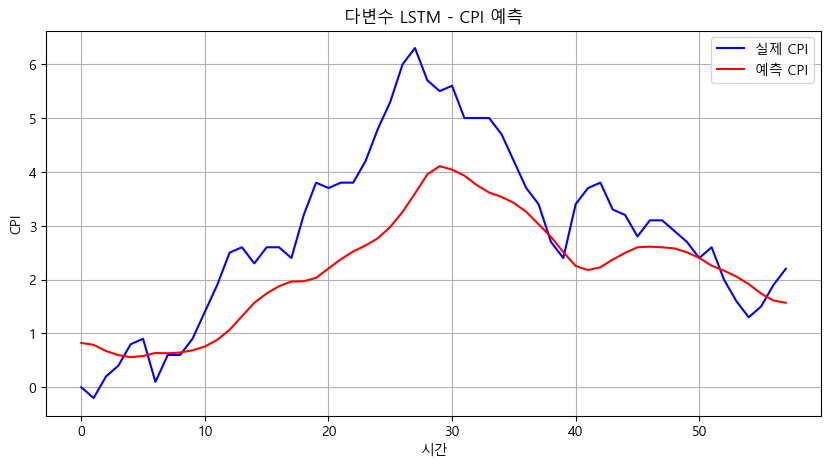

In [28]:
# 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="실제 CPI", color='blue')
plt.plot(y_pred_inv, label="예측 CPI", color='red')
plt.title("다변수 LSTM - CPI 예측")
plt.xlabel("시간")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# cpi 예측 탐색적 데이터 분석 EDA


In [30]:
# 1. 데이터 기본 구조 확인
print("✅ 데이터 크기:", merged_df.shape)
print("\n📋 컬럼 정보:")
print(merged_df.info())

# 2. 결측치 확인
print("\n❓ 결측치 확인:")
print(merged_df.isnull().sum())

# 3. 기초 통계
print("\n📊 기초 통계 요약:")
print(merged_df.describe())

✅ 데이터 크기: (301, 4)

📋 컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      301 non-null    datetime64[ns]
 1   CPI     301 non-null    float64       
 2   금리      301 non-null    float64       
 3   환율      301 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 9.5 KB
None

❓ 결측치 확인:
날짜     0
CPI    0
금리     0
환율     0
dtype: int64

📊 기초 통계 요약:
                                  날짜    CPI     금리      환율
count                            301 301.00 301.00  301.00
mean   2012-07-01 07:34:29.102990080   2.50   3.55 1153.00
min              2000-01-01 00:00:00  -0.40   0.83  900.70
25%              2006-04-01 00:00:00   1.40   2.06 1086.30
50%              2012-07-01 00:00:00   2.50   3.46 1143.00
75%              2018-10-01 00:00:00   3.40   4.77 1212.10
max              2025-01-01 00:00:00   6.30   9.28 15

C:\Users\human-09\AppData\Local\Temp\ipykernel_13912\1422149743.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


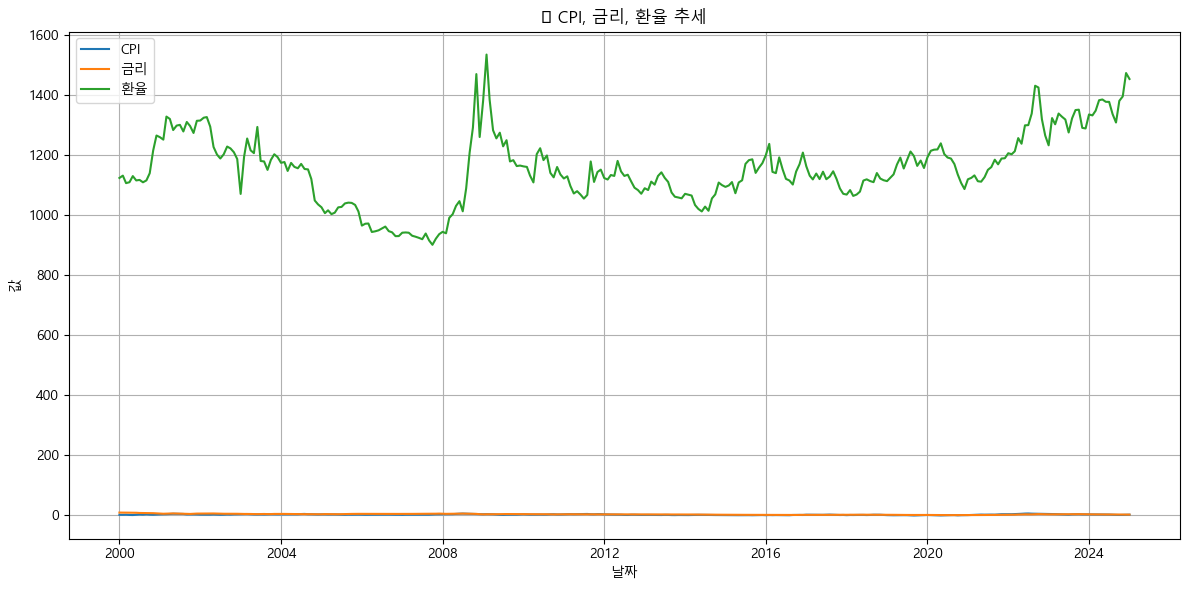

In [31]:
# 시계열 라인 플롯 (추세 확인)
plt.figure(figsize=(12, 6))
plt.plot(merged_df["날짜"], merged_df["CPI"], label="CPI")
plt.plot(merged_df["날짜"], merged_df["금리"], label="금리")
plt.plot(merged_df["날짜"], merged_df["환율"], label="환율")
plt.title("📈 CPI, 금리, 환율 추세")
plt.xlabel("날짜")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\human-09\AppData\Local\Temp\ipykernel_13912\3827381578.py:6: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


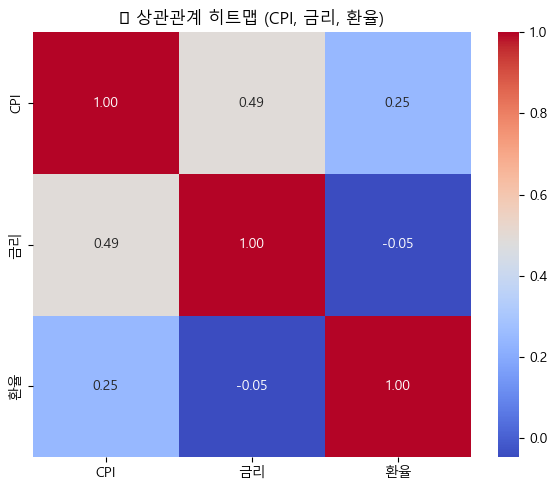

In [32]:
# 변수 간 상관관계 히트맵
plt.figure(figsize=(6, 5))
corr = merged_df[["CPI", "금리", "환율"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("📌 상관관계 히트맵 (CPI, 금리, 환율)")
plt.tight_layout()
plt.show()

C:\Users\human-09\AppData\Local\Temp\ipykernel_13912\2012984050.py:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


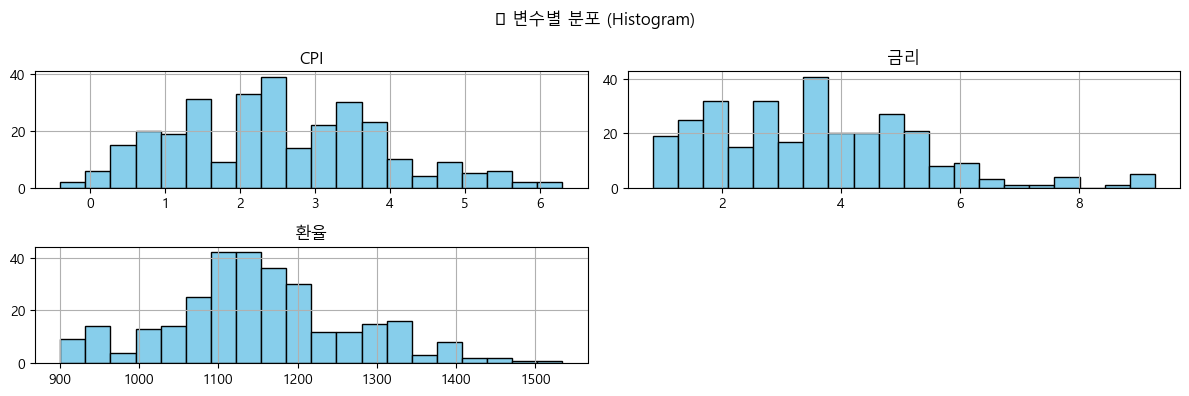

In [33]:
# 변수별 분포 (히스토그램)
merged_df[["CPI", "금리", "환율"]].hist(bins=20, figsize=(12, 4), color='skyblue', edgecolor='black')
plt.suptitle("📊 변수별 분포 (Histogram)")
plt.tight_layout()
plt.show()

c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


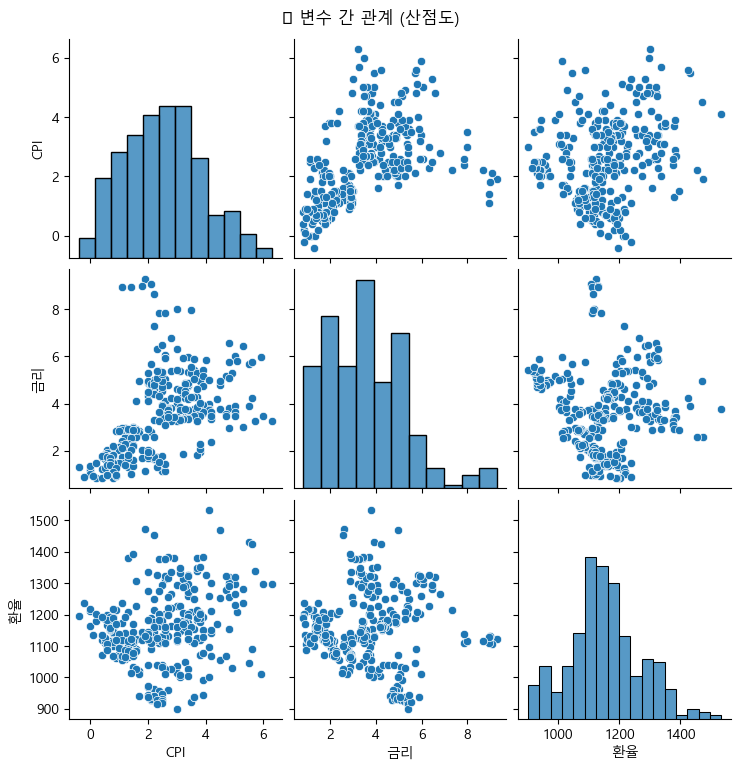

In [34]:
# 변수 간 산점도 (Scatter Plot)
sns.pairplot(merged_df[["CPI", "금리", "환율"]])
plt.suptitle("🔍 변수 간 관계 (산점도)", y=1.02)
plt.show()

c:\test\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


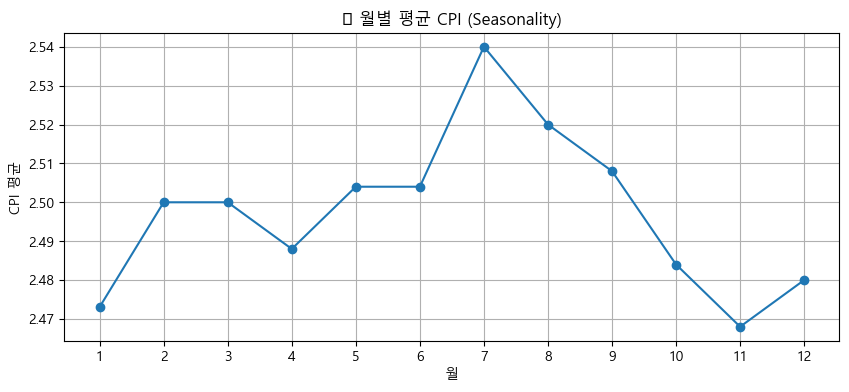

In [35]:
# 월별 평균 CPI 추세 (Seasonality 파악)# 
monthly_avg = merged_df.copy()
monthly_avg["연도"] = monthly_avg["날짜"].dt.year
monthly_avg["월"] = monthly_avg["날짜"].dt.month
monthly_cpi = monthly_avg.groupby("월")["CPI"].mean()

plt.figure(figsize=(10, 4))
plt.plot(monthly_cpi.index, monthly_cpi.values, marker='o')
plt.title("📆 월별 평균 CPI (Seasonality)")
plt.xlabel("월")
plt.ylabel("CPI 평균")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

In [36]:
print("✅ EDA 완료: 데이터 추세, 분포, 상관관계, 계절성 확인")

✅ EDA 완료: 데이터 추세, 분포, 상관관계, 계절성 확인


In [39]:
  

merged_cpi_df = pd.read_csv('merged_cpi_dataset.csv', parse_dates=['날짜'])

# 프로파일링 리포트 생성
profile = ProfileReport(merged_cpi_df, title="CPI 예측 모델용 데이터 프로파일링 리포트", explorative=True)

# HTML로 저장
profile.to_file("cpi_profiling_report.html")

Summarize dataset:  53%|█████▎    | 8/15 [00:00<00:00, 42.06it/s, scatter 금리, CPI]]          c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  plt.savefig(
c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.savefig(
Summarize dataset:  60%|██████    | 9/15 [00:00<00:00, 42.06it/s, scatter CPI, 금리]c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) Arial.
  plt.savefig(
c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils.py:73: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  plt.savefig(
Summarize dataset:  67%|██████▋   | 10/15 [00:00<00:00, 42.06it/s, scatter 금리, 금리]c:\test\.venv\lib\site-packages\ydata_profiling\visualisation\utils

In [48]:
from ydata_profiling import ProfileReport  # ✅ 반드시 필요
from streamlit_pandas_profiling import st_profile_report  # Streamlit에 출력하기 위해 필요
from streamlit_pandas_profiling import st_profile_report
import streamlit as st
# 모델 로딩을 캐싱하여 성능 최적화
@st.cache_resource
def load_model():
    return joblib.load("cpi_model.pkl")

model = load_model()

In [49]:
# -----------------------------------------
# 브라우저 탭에 표시될 제목을 설정

st.title("📈 CPI 예측 모델 대시보드")

# -----------------------------------------
# 1. 사용자로부터 데이터 업로드 받기
st.sidebar.header("📂 CSV 업로드")
uploaded_file = st.sidebar.file_uploader("CPI 예측용 CSV 파일을 업로드하세요", type="csv")
# 📊 데이터 프로파일링 리포트
from ydata_profiling import ProfileReport
from streamlit_pandas_profiling import st_profile_report
# 사용자가 CSV 파일을 업로드했을 때 실
if uploaded_file is not None:
    # CSV 읽기
    df = pd.read_csv(uploaded_file, parse_dates=['날짜'])  # 'date' 컬럼 필수
    st.subheader("✅ 업로드된 원본 데이터")
    st.dataframe(df.head())

    # -----------------------------------------
    # 2. YData Profiling 리포트 생성 및 출력
    st.subheader("📊 데이터 프로파일링 리포트")
    profile = ProfileReport(df, title="CPI 데이터 분석", explorative=True)
    st_profile_report(profile) # st_profile_report()를 통해 Streamlit 화면에 이 리포트를 표시합니다.

    # -----------------------------------------
    # 3. CPI 예측 수행
    st.subheader("🧠 CPI 예측 결과")

    # ✅ 예측에 사용할 피처
    feature_cols = ['CPI','금리', '환율']
    if all(col in df.columns for col in feature_cols):
        X = df[feature_cols].values
        y_pred = model.predict(X)

        # ⚠️ 예측 결과가 2차원이라면 1차원으로 변환
        if y_pred.ndim == 2:
            y_pred = y_pred.flatten()

        df['CPI_pred'] = y_pred
    else:
        st.error("❌ 예측에 필요한 컬럼이 누락되었습니다: " + ", ".join(feature_cols))
        st.stop()

    # -----------------------------------------
    # 4. 시계열 차트 시각화
    st.subheader("📈 실제 vs 예측 CPI 시계열")
    try:
        st.line_chart(df.set_index('날짜')[['CPI', 'CPI_pred']])
    except Exception as e:
        st.warning("시계열 차트를 그리는 중 문제가 발생했습니다.")
        st.exception(e)

    # -----------------------------------------
    # 5. 성능 지표 계산 및 표시
    st.subheader("📌 예측 성능 지표")

    mae = mean_absolute_error(df['CPI'], df['CPI_pred'])
    rmse = np.sqrt(mean_squared_error(df['CPI'], df['CPI_pred']))
    r2 = r2_score(df['CPI'], df['CPI_pred'])

    col1, col2, col3 = st.columns(3)
    col1.metric("📉 MAE", f"{mae:.4f}")
    col2.metric("📊 RMSE", f"{rmse:.4f}")
    col3.metric("📈 R² Score", f"{r2:.4f}")
else:
    st.info("왼쪽 사이드바에서 CSV 파일을 업로드하면 분석 결과가 표시됩니다.")

2025-03-25 17:30:08.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2025-03-25 17:30:08.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 17:30:08.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
